This file is part of https://github.com/diehlpk/reusommer21.

Copyright (c) 2021 Patrick Diehl

This program is free software: you can redistribute it and/or modify  
it under the terms of the GNU General Public License as published by  
the Free Software Foundation, version 3.

This program is distributed in the hope that it will be useful, but 
WITHOUT ANY WARRANTY; without even the implied warranty of 
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. 
If not, see <http://www.gnu.org/licenses/>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
example = "Quartic"
save_results = True
has_condition = True
g = -1
con = []

In [3]:
#############################################################################
# Exact solution 
#############################################################################

def exactSolution(x):
    
    if example == "Cubic":
        return x * x * x
    elif example == "Quartic":
        return x * x * x * x
    elif example == "Quadratic":
        return x * x
    elif example == "Linear":
        return x
    elif example == "Linear-cubic":
        return np.where(x < 1.5, x, x + (x-1.5) * (x-1.5) * (x-1.5) )
    else:
        print("Error: Either provide Linear, Quadratic, Quartic, or Cubic")
        sys.exit()

In [4]:
#############################################################################
# Solve the system
#############################################################################

def solve(M,f):
    return np.linalg.solve(M,f)

In [5]:
#############################################################################
# Loading
#############################################################################

def f(x):
    
    global g 

    if example == "Cubic":
        g = 27
        return -6*x
    elif example == "Quartic":
        g = 108
        return -12 * x*x
    elif example == "Quadratic":
        g = 6
        return -2
    elif example == "Linear":
        g = 1
        return 0
    elif example == "Linear-cubic":
        g = 31./4.
        if x < 1.5:
            return 0 
        else:
            return 9-6*x
    else:
        print("Error: Either provide Quadratic, Quartic, or Cubic")
        sys.exit()

def forceFull(n,x):
    
    force = np.zeros(n)
   
    for i in range(1,n-1):
        force[i] = f(x[i]) / exactSolution(x[n-1])
    
    force[n-1] = g / exactSolution(x[n-1])
    
    return force

def forceCoupling(n,x):
    
    dim = 2*n + 2*n-1 + 4
    
    force = np.zeros(dim)
   
    for i in range(1,dim-1):
        force[i] = f(x[i]) / exactSolution(x[dim-1])
    
    force[dim-1] = g / exactSolution(x[dim-1])
    
    return force

In [6]:
#############################################################################
# Assemble the stiffness matrix for the finite difference model (FD)
#############################################################################

def FDM(n,h):

    M = np.zeros([n,n])

    M[0][0] = 1

    for i in range(1,n-1):
        M[i][i-1] = -2
        M[i][i] = 4
        M[i][i+1] = -2

    
    M[n-1][n-1] = 11*h / 3
    M[n-1][n-2] = -18*h / 3
    M[n-1][n-3] = 9 * h / 3
    M[n-1][n-4] = -2 * h / 3

    M *= 1./(2.*h*h)

    return M

In [7]:
#############################################################################
# Assemble the stiffness matrix for the coupling of FDM - VHM - FDM
#############################################################################

def CouplingMDCM(n,h,x):

    fVHM = 1./(8.*h/2*h/2)
    fFDM = 1./(2.*h*h)
    
    dim = 2*n + 2*n-1 + 4
    
    M = np.zeros([dim,dim])
    
    M[0][0] = 1 

    for i in range(1,n-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM 
    
    M[n-1][n-1] = -1 
    M[n-1][n+2] = 1  
    
    M[n][n] = -1
    M[n][n-2] = 1
    
    M[n+1][n+1] = -1
    M[n+1][n-4] = 1/16
    M[n+1][n-3] = -5/16
    M[n+1][n-2] = 15/16
    M[n+1][n-1] = 5/16
         
    mid = n+2*n+1
    
    for i in range(n+2,mid):
        M[i][i-2] = -1. * fVHM
        M[i][i-1] = -4. * fVHM
        M[i][i] = 10. * fVHM
        M[i][i+1] =  -4. * fVHM
        M[i][i+2] = -1. * fVHM
        
    M[mid][mid] = -1 
    M[mid][mid+2] = 5/16
    M[mid][mid+3] = 15/16
    M[mid][mid+4] = -5/16
    M[mid][mid+5] = 1/16
    

    M[mid+1][mid+1] = -1
    M[mid+1][mid+3] = 1
    
    M[mid+2][mid+2] = -1
    M[mid+2][mid-1] = 1
    
    for i in range(mid+3,dim-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM

    M[dim-1][dim-1] = 11 *  h * fFDM / 3
    M[dim-1][dim-2] =  -18 * h * fFDM  / 3
    M[dim-1][dim-3] = 9 * h * fFDM / 3
    M[dim-1][dim-4] = -2 * h * fFDM / 3
    
    if has_condition:
        con.append(np.linalg.cond(M))
         
    return M

In [8]:
def compute(i):
    
    n = np.power(2,int(i))
    h = 1./n
    nodes = n + 1
    
    print(nodes,h)
    x1 = np.linspace(0,1,nodes)
    x2 = np.linspace(1-2*h/2,2.+2*h/2,2*nodes-1+4)
    x3 = np.linspace(2,3.,nodes)
    x = np.array(np.concatenate((x1,x2,x3)))
  
    M = CouplingMDCM(nodes,h,x)
    
    f = forceCoupling(nodes,x)
    
    f[n] = 0
    f[n+1] = 0
    f[n+2] = 0
    
    mid = n+2*n+3
     
    f[mid+1] = 0
    f[mid+2] = 0
    f[mid+3] = 0
    
    u = solve(M,f)
      
    x1 = x[0:nodes-1]
    x2 = x[nodes+2:mid+1:2]
    x3 = x[mid+4:len(x)]
    
    u1 = u[0:nodes-1]
    u2 = u[nodes+2:mid+1:2]
    u3 = u[mid+4:len(x)]
    
    x = np.concatenate([x1,x2,x3])
    u = np.concatenate([u1,u2,u3])
    
    plt.plot(x,u,label="$hFD=$"+str(h))
    plt.grid(True)
    
    x = np.arange(0,3+h,h)
    interval = int(len(x)/3)
    
    forceFD = forceFull(len(x),x)
    MFD = FDM(len(x),h)
    
    uFM = solve(MFD,forceFD)
        
    uFD = uFM
        
    if save_results:
        np.savetxt("u_mdcm_n_cubic_"+str(n)+".csv", u, delimiter=",")
    
    return u , uFD , x

17 0.0625
33 0.03125
65 0.015625
129 0.0078125


Text(0.5, 1.0, 'Quadratic solution ')

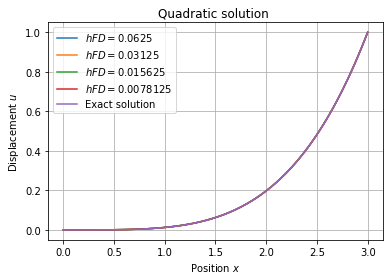

In [9]:
uCoupled = []
uLocal = []
xLocal = []
max_iteration = 8

for i in range(4,max_iteration):
    u , uFD , x = compute(i)
    uCoupled.append(u)
    uLocal.append(uFD)
    xLocal.append(x)

n = np.power(2,int(max_iteration))
h = 1./n

x = np.arange(0,3+h,h)
plt.plot(x,exactSolution(x)/exactSolution(x[len(x)-1]),label="Exact solution")#
plt.legend()
plt.xlabel(r"Position $x$")
plt.ylabel(r"Displacement $u$")
plt.title(r"Quadratic solution ")
#plt.savefig("coupling-vhm-"+str(example)+"-dirchelt.pdf")

  0.000045
  0.000012
  0.000003
  0.000001


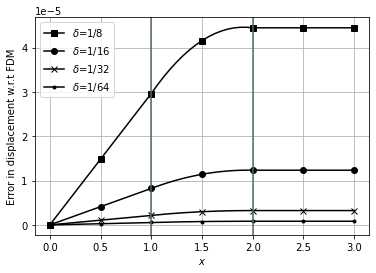

In [10]:
plt.clf()
markers = ['s','o','x','.']
level = [8,16,32,64]

for i in range(0,len(xLocal)):
    n = np.power(2,i+4)
    plt.plot(xLocal[i],uLocal[i]-uCoupled[i],color="black",marker=markers[i],markevery=level[i],label=r"$\delta$=1/"+str(int(n/2)))
    print('{0:10f}'.format(max(abs(uLocal[i]-uCoupled[i]))))
    
plt.xlabel(r"$x$")
plt.ylabel(r"Error in displacement w.r.t FDM")
#plt.title(r"Example with " + str(example).lower() + " solution for MDCM with m = 2")
plt.grid()
plt.axvline(x=1,c="#536872")
plt.axvline(x=2,c="#536872")
plt.legend()
plt.savefig("coupling-MDCM-"+str(example)+"-neumann-error.pdf",bbox_inches='tight')

if has_condition :
    np.savetxt("con_mdcm_n.csv", con, delimiter=",")